In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

train_df = pd.read_csv('../data_file/fill_na_train.csv')
test_df = pd.read_csv('../data_file/fill_na_test.csv')

In [4]:
train_df.groupby('building_number').total_area.mean().sort_values()

building_number
13    5.578400e+03
36    8.816490e+03
35    9.736000e+03
34    1.066500e+04
58    1.489700e+04
          ...     
25    5.280141e+05
27    5.784841e+05
24    6.596969e+05
61    6.671310e+05
20    1.287288e+07
Name: total_area, Length: 100, dtype: float64

In [5]:
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df.set_index('date_time', inplace=True)

In [6]:
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

data_grouped = train_df.groupby('building_number').resample('H').mean()

In [7]:
def z_score_method(series ,lower_threshold = 1.5, upper_threshold=1.5):
    """
    Apply the Z-score method for anomaly detection
    
    Args:
    series: Time series data
    threshold: Z-score threshold for anomaly detection. Defaults to 3.
    
    Returns:
    An array containing the indices of the anomalies
    """
    # Calculate z-scores
    z_scores = (series - series.mean()) / series.std()
    
    # Identify anomalies
    anomalies = np.where((z_scores > lower_threshold) | (z_scores < -upper_threshold))
    
    return anomalies

In [8]:
def plot_residuals(building_index, lower=1.5, upper=2.0):

    decomposition_building = seasonal_decompose(data_grouped.loc[building_index]['power_consumption'], model='additive', period=24)

    # Drop NaN values from residuals
    residuals_building = decomposition_building.trend

    # Calculate the IQR of the residuals
    Q1_resid_building = residuals_building.quantile(0.25)
    Q3_resid_building = residuals_building.quantile(0.75)
    IQR_resid_building = Q3_resid_building - Q1_resid_building

    # Define the thresholds for outliers
    lower_threshold_resid_building = Q1_resid_building - lower * IQR_resid_building
    upper_threshold_resid_building = Q3_resid_building + upper * IQR_resid_building

    # Identify the outliers
    outliers_resid_building = residuals_building[(residuals_building < lower_threshold_resid_building) | 
                                                     (residuals_building > upper_threshold_resid_building)]

    # Convert the outliers' indices to match the original data's indices
    outliers_resid_indices_building = data_grouped.loc[building_index].index[data_grouped.loc[building_index].index.isin(outliers_resid_building.index)]

    # Get the corresponding 'power_consumption' values for these indices
    outliers_resid_original_building = data_grouped.loc[building_index, 'power_consumption'].loc[outliers_resid_indices_building]

    # Plot the original data and the outliers
    plt.figure(figsize=(12,6))
    plt.plot(data_grouped.loc[building_index]['power_consumption'], label='Original')
    plt.scatter(outliers_resid_original_building.index, outliers_resid_original_building, color='red', label='Outliers')
    plt.legend(loc='best')
    plt.title(f'Power Consumption for Building Number {building_index} with Outliers of Residuals')
    plt.show()

In [9]:
def plot_trend(building_index, lower=1.8, upper=2.5):
    data_building = train_df[train_df['building_number'] == building_index]

    # Set date_time as the index
    data_building.set_index('date_time', inplace=True)

    # Apply seasonal decomposition
    decomposition = seasonal_decompose(data_building['power_consumption'], model='additive', period=24)

    # Apply Z-score method to trend
    trend = decomposition.trend.dropna()  # Remove missing values
    anomalies_trend = z_score_method(trend, lower, upper)

    # Print number of anomalies detected
    print(f"Number of anomalies detected in trend: {len(anomalies_trend[0])}")

    # Plot power consumption over time, highlighting anomalies
    plt.figure(figsize=(15, 8))
    plt.plot(data_building.index, data_building['power_consumption'], label='Power consumption')
    plt.scatter(trend.index[anomalies_trend], data_building['power_consumption'].loc[trend.index[anomalies_trend]], color='red', label='Anomalies')
    plt.title('Power Consumption Over Time (Building 17)')
    plt.xlabel('Time')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.show()

In [10]:
train_df.reset_index(inplace=True)

In [11]:
train_df

,date_time,building_number,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,day,discomfort_index,cdh,total_area_x_cdh,cooling_area_x_cdh,week,sin_time,cos_time,holiday
0,2022-06-01 00:00:00,1,1085.28,Other Buildings,110634.00,39570.00,0.0,2,63.09388,-5.4,-5.974236,-2.136780,22,0.000000,1.000000,1
1,2022-06-01 01:00:00,1,1047.36,Other Buildings,110634.00,39570.00,0.0,2,62.46400,-11.4,-12.612276,-4.510980,22,0.258819,0.965926,1
2,2022-06-01 02:00:00,1,974.88,Other Buildings,110634.00,39570.00,0.0,2,62.08735,-17.7,-19.582218,-7.003890,22,0.500000,0.866025,1
3,2022-06-01 03:00:00,1,953.76,Other Buildings,110634.00,39570.00,0.0,2,60.89884,-25.0,-27.658500,-9.892500,22,0.707107,0.707107,1
4,2022-06-01 04:00:00,1,986.40,Other Buildings,110634.00,39570.00,0.0,2,62.88788,-30.6,-33.854004,-12.108420,22,0.866025,0.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,2022-08-24 19:00:00,100,881.04,Hotel and Resort,57497.84,40035.23,0.0,2,72.38034,4.4,2.529905,1.761550,34,-0.965926,0.258819,0
203996,2022-08-24 20:00:00,100,798.96,Hotel and Resort,57497.84,40035.23,0.0,2,71.21736,3.8,2.184918,1.521339,34,-0.866025,0.500000,0
203997,2022-08-24 21:00:00,100,825.12,Hotel and Resort,57497.84,40035.23,0.0,2,69.79704,1.7,0.977463,0.680599,34,-0.707107,0.707107,0
203998,2022-08-24 22:00:00,100,640.08,Hotel and Resort,57497.84,40035.23,0.0,2,69.41060,-1.1,-0.632476,-0.440388,34,-0.500000,0.866025,0


# isolationforest 이용하기

In [12]:
train_df[(train_df['building_number'] == 20)& (train_df['day'] == 1)]

,date_time,building_number,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,day,discomfort_index,cdh,total_area_x_cdh,cooling_area_x_cdh,week,sin_time,cos_time,holiday
38904,2022-06-07 00:00:00,20,940.32,Public,12872877.0,10941945.0,0.0,1,62.47150,-45.7,-5882.904789,-5000.468865,23,0.000000,1.000000,0
38905,2022-06-07 01:00:00,20,921.12,Public,12872877.0,10941945.0,0.0,1,60.86176,-48.2,-6204.726714,-5274.017490,23,0.258819,0.965926,0
38906,2022-06-07 02:00:00,20,917.76,Public,12872877.0,10941945.0,0.0,1,59.87467,-52.9,-6809.751933,-5788.288905,23,0.500000,0.866025,0
38907,2022-06-07 03:00:00,20,931.68,Public,12872877.0,10941945.0,0.0,1,58.69372,-60.4,-7775.217708,-6608.934780,23,0.707107,0.707107,0
38908,2022-06-07 04:00:00,20,923.04,Public,12872877.0,10941945.0,0.0,1,58.08405,-67.9,-8740.683483,-7429.580655,23,0.866025,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40771,2022-08-23 19:00:00,20,1411.68,Public,12872877.0,10941945.0,0.0,1,75.32864,1.8,231.711786,196.955010,34,-0.965926,0.258819,0
40772,2022-08-23 20:00:00,20,1270.56,Public,12872877.0,10941945.0,0.0,1,75.40315,2.9,373.313433,317.316405,34,-0.866025,0.500000,0
40773,2022-08-23 21:00:00,20,1155.84,Public,12872877.0,10941945.0,0.0,1,75.50270,3.5,450.550695,382.968075,34,-0.707107,0.707107,0
40774,2022-08-23 22:00:00,20,1085.76,Public,12872877.0,10941945.0,0.0,1,74.17751,3.1,399.059187,339.200295,34,-0.500000,0.866025,0


In [13]:
from sklearn.ensemble import IsolationForest


def isolate(building_number, contamin = 0.05):
# Filter the dataset for building number 1

    data_building = train_df[train_df['building_number'] == building_number]
#     data_building = train_df[train_df['building_number'] == building_number]

    # Create an instance of IsolationForest
    iso_forest = IsolationForest(contamination=contamin, random_state=42)  # contamination parameter determines the proportion of outliers in the dataset

    # Fit the model on power_consumption column
    iso_forest.fit(data_building[['power_consumption']])

    # Predict the outliers
    data_building['outliers'] = iso_forest.predict(data_building[['power_consumption']])
    
    plt.figure(figsize=(10,6))
    plt.plot(data_building.index, data_building['power_consumption'], color='b', label='inliers')
    plt.scatter(data_building[data_building['outliers'] == -1].index, data_building[data_building['outliers'] == -1]['power_consumption'], color='r', label='outliers')
    plt.title('Power Consumption Outliers in Building ')
    plt.xlabel('Index')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.show()

/var/folders/__/r8r58jz17gj32tjwycl0m0hr0000gn/T/ipykernel_59889/2621848330.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_building['outliers'] = iso_forest.predict(data_building[['power_consumption']])


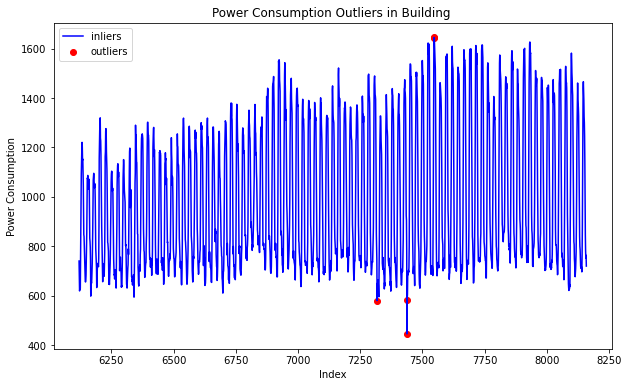

In [29]:
isolate(4, contamin = 0.002)

/var/folders/__/r8r58jz17gj32tjwycl0m0hr0000gn/T/ipykernel_59889/2621848330.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_building['outliers'] = iso_forest.predict(data_building[['power_consumption']])


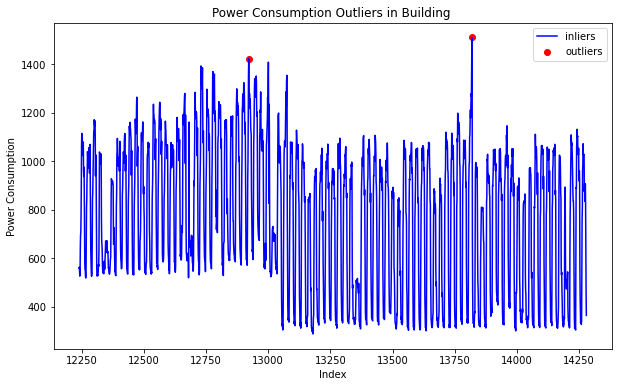

In [34]:
isolate(7, contamin = 0.0005)

/var/folders/__/r8r58jz17gj32tjwycl0m0hr0000gn/T/ipykernel_59889/2621848330.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_building['outliers'] = iso_forest.predict(data_building[['power_consumption']])


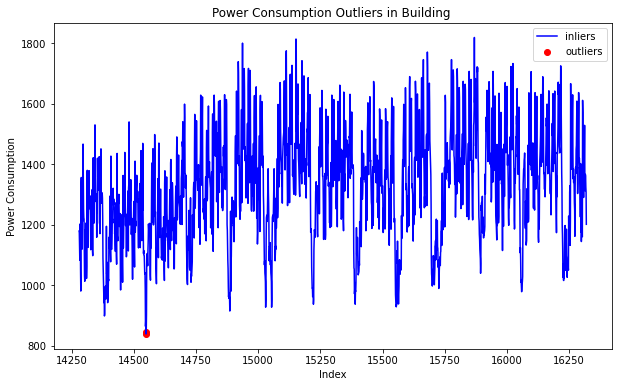

In [35]:
isolate(8, contamin = 0.0005)

/var/folders/__/r8r58jz17gj32tjwycl0m0hr0000gn/T/ipykernel_59889/2621848330.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_building['outliers'] = iso_forest.predict(data_building[['power_consumption']])


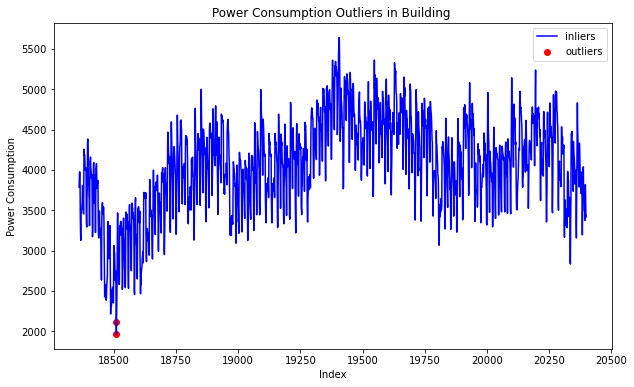

In [38]:
isolate(10, contamin = 0.0005)

/var/folders/__/r8r58jz17gj32tjwycl0m0hr0000gn/T/ipykernel_58022/1720221850.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_building['outliers'] = iso_forest.predict(data_building[['power_consumption']])


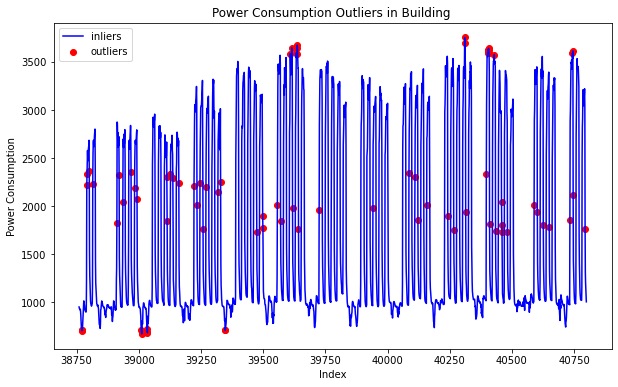

In [64]:
isolate(20)

/var/folders/__/r8r58jz17gj32tjwycl0m0hr0000gn/T/ipykernel_58022/1714686072.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_building['outliers'] = iso_forest.predict(data_building[['power_consumption']])


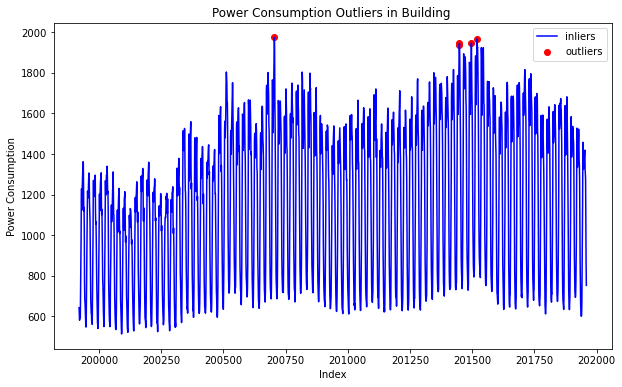

In [40]:
isolate(99)

/var/folders/__/r8r58jz17gj32tjwycl0m0hr0000gn/T/ipykernel_58022/1714686072.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_building['outliers'] = iso_forest.predict(data_building[['power_consumption']])


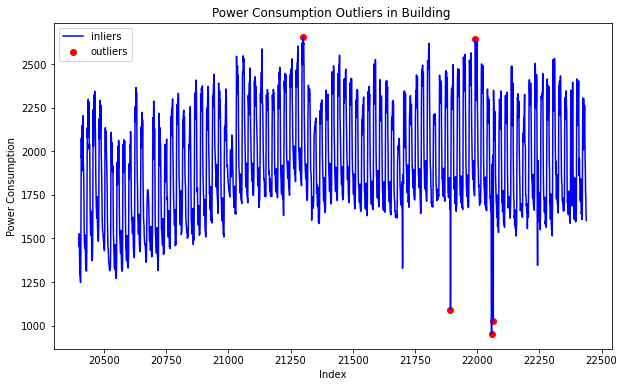

In [27]:
isolate(11)

/var/folders/__/r8r58jz17gj32tjwycl0m0hr0000gn/T/ipykernel_58022/1714686072.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_building['outliers'] = iso_forest.predict(data_building[['power_consumption']])


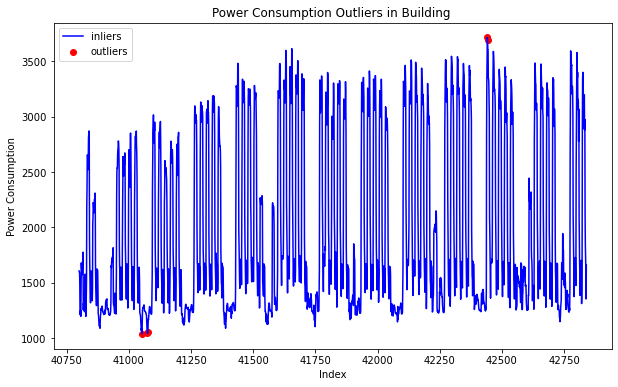

In [29]:
isolate(21)

Number of anomalies detected in trend: 462


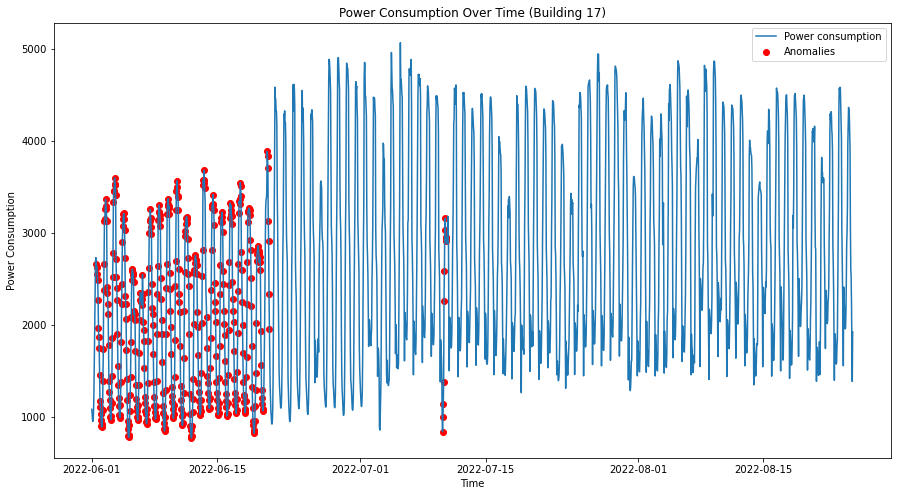

In [24]:
plot_trend(1, 2, 1)

Number of anomalies detected in trend: 113


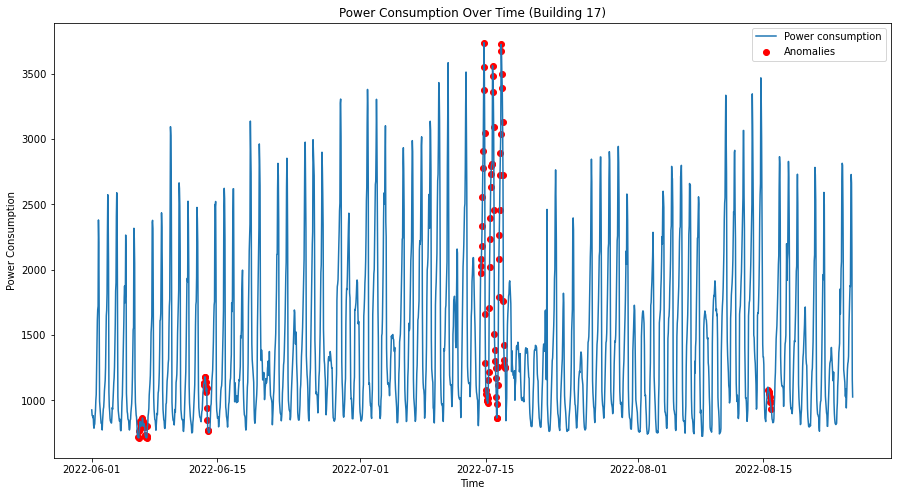

In [233]:
plot_trend(3)